In [1]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import os

In [2]:
# Flag for using Google Colab
colab_on = False
base_path = ""

In [3]:
# if we are using google colab we need to mount the drive
# and set the base path to the root of the drive
if colab_on:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = '/content/drive/My Drive/assignment2'

Mounted at /content/drive


In [4]:
# Loading the data
X = np.load(os.path.join(base_path, 'x_letters.npy'))
y = np.load(os.path.join(base_path, 'y_letters.npy'))

# Converting data to respectively float32 and int64
X = X.astype(np.float32)
y = y.astype(np.int64)

In [5]:
# one hot encoding the labels
y = keras.utils.to_categorical(y, 26)
n_classes = y.shape[1]

In [6]:
X.shape, y.shape

((88799, 28, 28), (88799, 26))

In [93]:
batch_size = 64

In [94]:
# We are combining X and y into singular tensorflow dataset
# because the data is ordered (all examples of 0, then all examples of 1, etc.), we need to shuffle it, so our splits contain all classes
dataset = tf.data.Dataset.from_tensor_slices((X, y))
dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True).batch(batch_size)

In [120]:
#Source: https://keras.io/examples/generative/dcgan_overriding_train_step/
# We reused a lot of code from the class (like training loop) with small changes like gradient clipping

class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data):
        # Sample random points in the latent space

        real_images, real_classes = data
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim),
            seed = self.seed_generator
        )

        # Decode them to fake images
        generated_images = self.generator([random_latent_vectors, real_classes])

        # Combine them with real images
        real_images = real_images * 2 - 1  # Rescale to [-1, 1], because the generator outputs images in the same range (using tanh as last activation function)
        combined_images = ops.concatenate([generated_images, real_images], axis=0)
        combined_classes = ops.concatenate([real_classes, real_classes], axis=0)

        # Assemble labels discriminating real from fake images
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)) * 0.9, ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        #basically makes sure the discriminator is not perfect,
        #so that the generator never has a chance to learn
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_classes])
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

        # Clip gradients for training stability 
        # basically makes sure the gradients are not too big
        # by clipping them to a certain value if they are over that value
        grads = [tf.clip_by_value(g, -1.0, 1.0) for g in grads]

        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim),
            seed = self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            generated_images = self.generator([random_latent_vectors, real_classes])
            predictions = self.discriminator([generated_images, real_classes])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        # Clip gradients for stability
        grads = [tf.clip_by_value(g, -1.0, 1.0) for g in grads]
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [131]:
latent_dim = 64

# Now that we are dealing with models that accept more than one input, we need to change the way we build them
# We are not using the Sequential API, but the Functional API
# We get the noise and one hot encoded label as input and concatenate them into single vectors
# meaning that if our latent_dim is 64 and we have 26 classes, the input to the generator will be 90 (last dim of the shape)

# in both gen and disc we are using leaky relu instead of relu
# especially in discriminator it makes sense, becasue we want to allow for some negative values

# because the generator is a bit harder to train, we are using batch normalization and lower than default momentum
# to stabilize the training
# lower momentum allows for faster adaptation to the changes
# with batch norm bias is not needed, because it is already included in the batch norm layer (shift parameter)
# also we found out that it is common to use tanh as activation function in the last layer of the generator (it just empirically works better)
def build_generator():
    noise_input = keras.Input(shape=(latent_dim,))
    label_input = keras.Input(shape=(n_classes,))

    x = layers.Concatenate(axis=-1)([noise_input, label_input])

    x = keras.layers.Dense(128, use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.8)(x)  
    x = keras.layers.LeakyReLU(0.2)(x)

    x = keras.layers.Dense(256, use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.8)(x)
    x = keras.layers.LeakyReLU(0.2)(x)

    x = keras.layers.Dense(28*28, activation='tanh')(x)
    output = layers.Reshape((28, 28))(x)

    return keras.Model([noise_input, label_input], output, name="generator")

# In discriminator we are doing the same thing
# So we are accepting the image and one hot encoded label as input and concatenating them into single vector
# First we flatten the image and then concatenate it with the label
# Now the shape of the input is 28*28 + 26 = 784 + 26 = 810


# Because the descriminator learns much faster than the generator, we are using dropout to slow it down and regularize it
# also we don't want label information to dominate too early,
# that's why we are first learning infrastructure of the image and then combining it with the label
def build_discriminator():
    image_input = keras.Input(shape=(28, 28))
    label_input = keras.Input(shape=(n_classes,))


    x = layers.Flatten()(image_input)

    x = keras.layers.Dense(256)(x)
    x = keras.layers.LeakyReLU(0.2)(x)
    x = keras.layers.Dropout(0.4)(x)  

    x = keras.layers.Dense(128)(x)
    x = keras.layers.LeakyReLU(0.2)(x)
    x = keras.layers.Dropout(0.4)(x)

    # Combine with class embedding
    x = keras.layers.Concatenate(axis=-1)([x, label_input])

    # Output with extra dense layer for stability
    x = keras.layers.Dense(64)(x)
    x = keras.layers.LeakyReLU(0.2)(x)

    output = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model([image_input, label_input], output, name="discriminator")


generator = build_generator()
discriminator = build_discriminator()

# because our setup was rather stable we could allow for more epochs (200)
epochs = 200

# the generator has higher learning rate, because it is harder to train
# empiracally we decided to use adam just with much smaller momentum, which means we are adapting to the changes faster
# it works because training gan is quite unstable and we need to adapt to the changes quickly

# also empically a little bit higher learning rate for the discriminator worked better
# we guess it is because if generator had to high lr, it could become unstable, jump in solution space
gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(
        learning_rate=0.0002,
        beta_1=0.5,
        beta_2=0.999
    ),
    g_optimizer=keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.5,
        beta_2=0.999
    ),
    loss_fn=keras.losses.BinaryCrossentropy(),
)


In [132]:
gan.fit(dataset, epochs=epochs)

Epoch 1/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - d_loss: 0.3270 - g_loss: 1.7433
Epoch 2/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.2928 - g_loss: 2.2431
Epoch 3/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3097 - g_loss: 2.1403
Epoch 4/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3048 - g_loss: 2.2210
Epoch 5/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3028 - g_loss: 2.2931
Epoch 6/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3061 - g_loss: 2.2974
Epoch 7/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3082 - g_loss: 2.2962
Epoch 8/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3106 - g_loss: 2.2894
Epoch 9/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3102 - g_loss: 2.2892
Epoch 10/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3171 - g_loss: 2.2499
Epoch 11/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3152 - g_loss: 2.2524
Epoch 12/200
1388/

In [133]:
# We are using the mapping table to get the index of the letter (class) to onehot
MAPPING_TABLE = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7,
    'i': 8,
    'j': 9,
    'k': 10,
    'l': 11,
    'm': 12,
    'n': 13,
    'o': 14,
    'p': 15,
    'q': 16,
    'r': 17,
    's': 18,
    't': 19,
    'u': 20,
    'v': 21,
    'w': 22,
    'x': 23,
    'y': 24,
    'z': 25
}

# when generating letter we accept letter as input
# check which class it belongs to, one hot it and concatenate it with the random latent vector generated from normal distribution
def generate_letter(letter):
  mapped_letter = MAPPING_TABLE[letter]
  random_latent_vectors = keras.random.normal(shape=(1, latent_dim))
  one_hot_label = (ops.one_hot(mapped_letter, num_classes=n_classes))
  # we need to expand the dimensions of the one hot label, because the generator expects it (batch of 1)
  one_hot_label = tf.expand_dims(one_hot_label, axis=0)
  generated_images = gan.generator([random_latent_vectors, one_hot_label])
  generated_images = generated_images.numpy()[0]

  return generated_images

In [134]:
# when plotting the string we just loop through the letters and generate them one by one
def plot_string(word):

  _, ax = plt.subplots(1, len(word), figsize=(len(word)*2, 2))
  for i in range(len(word)):
    generated_letter = generate_letter(word[i])
    ax[i].imshow(generated_letter, cmap='gray')
    ax[i].axis('off')

  plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()


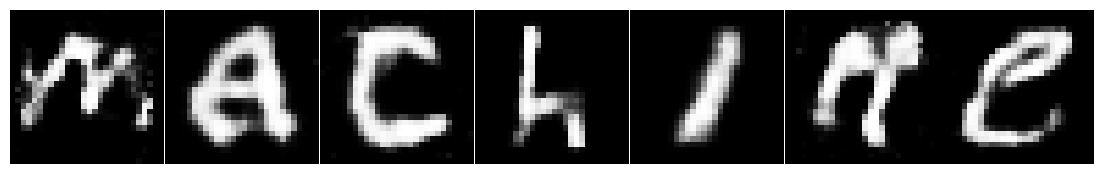

In [138]:
plot_string("machine")

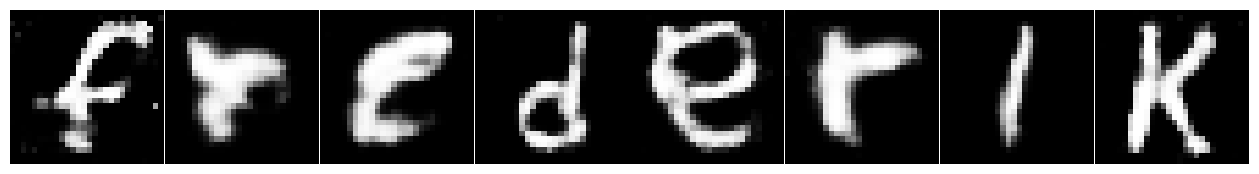

In [139]:
plot_string("frederik")

In [25]:
# another interesting thing we can do is to interpolate between two letters
# this means that our generator will start by generating the first letter and then slowly morph into the second letter with next images
# we can control the number of steps between the two letters

# we can achieve this by interpolating between the two latent vectors
# we interpolate both the latent vector and the one hot encoded label
def show_interpolation(from_letter, to_letter, n_steps=10):
    # get the latent vectors for the two letters
    latent_1 = keras.random.normal(shape=(1, latent_dim))
    latent_2 = keras.random.normal(shape=(1, latent_dim))

    letter_1 = MAPPING_TABLE[from_letter]
    letter_2 = MAPPING_TABLE[to_letter]

    # get the one hot encoded labels for the two letters
    one_hot_label_1 = (ops.one_hot(letter_1, num_classes=n_classes))
    one_hot_label_2 = (ops.one_hot(letter_2, num_classes=n_classes))

    # get the alpha values for the interpolation
    alpha_values = np.linspace(0, 1, n_steps)

    _, ax = plt.subplots(1, n_steps, figsize=(n_steps*2, 2))

    for i, alpha in enumerate(alpha_values):
        # interpolate the latent vector and the one hot encoded label
        latent = (1-alpha) * latent_1 + alpha * latent_2
        one_hot_label = (1-alpha) * one_hot_label_1 + alpha * one_hot_label_2
        one_hot_label = tf.expand_dims(one_hot_label, axis=0)
        # generate the morphing image
        generated_image = (gan.generator([latent, one_hot_label])).numpy()
        ax[i].imshow(generated_image[0], cmap='gray')
        ax[i].axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()


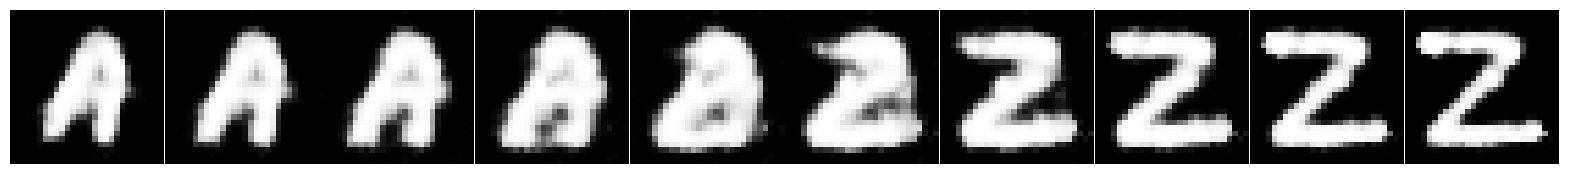

In [140]:
show_interpolation('a', 'z')

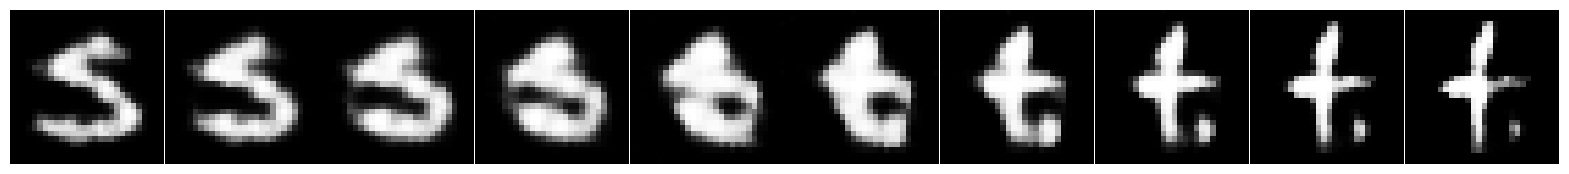

In [141]:
show_interpolation('s','t')

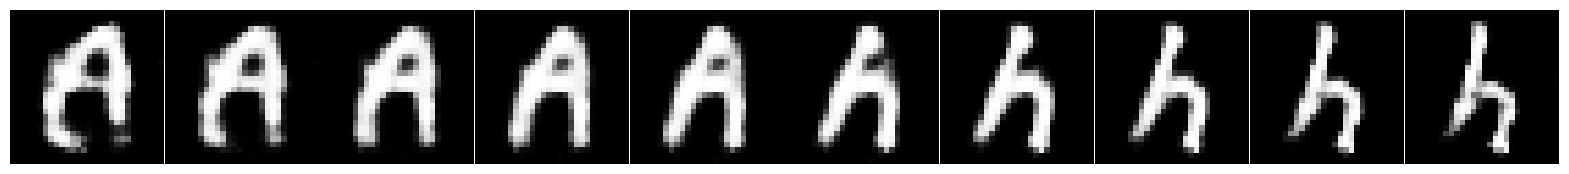

In [142]:
show_interpolation('a','h')